<div align='center'>

# Transfer Learning and Fine-tuning
    
</div>

In [1]:
# Load the neccessary packages
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data Preprocessing

### Data download

In [2]:
# Download the dataset 
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

# Get the path for training and validation dataset
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# Define the batch size and image size that will be used throughout the lab
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# Load the train dataset using image_dataset_from_directory
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [3]:
# load the validation dataset using image_dataset_from_directory
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


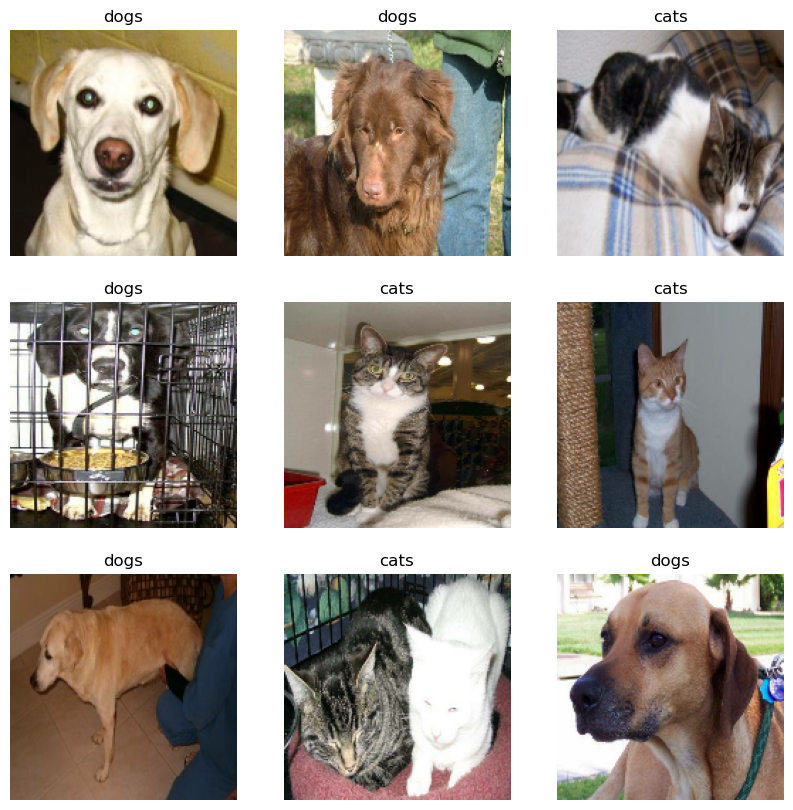

In [4]:
# Show the nine images and their labels
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
# Create the validation batches and test batches
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

In [7]:
# Define AUTOTUNE to increase the resource usage efficiency
AUTOTUNE = tf.data.AUTOTUNE

# Using prefetch for better use of resource and help training time
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

In [8]:
# Define the data_augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

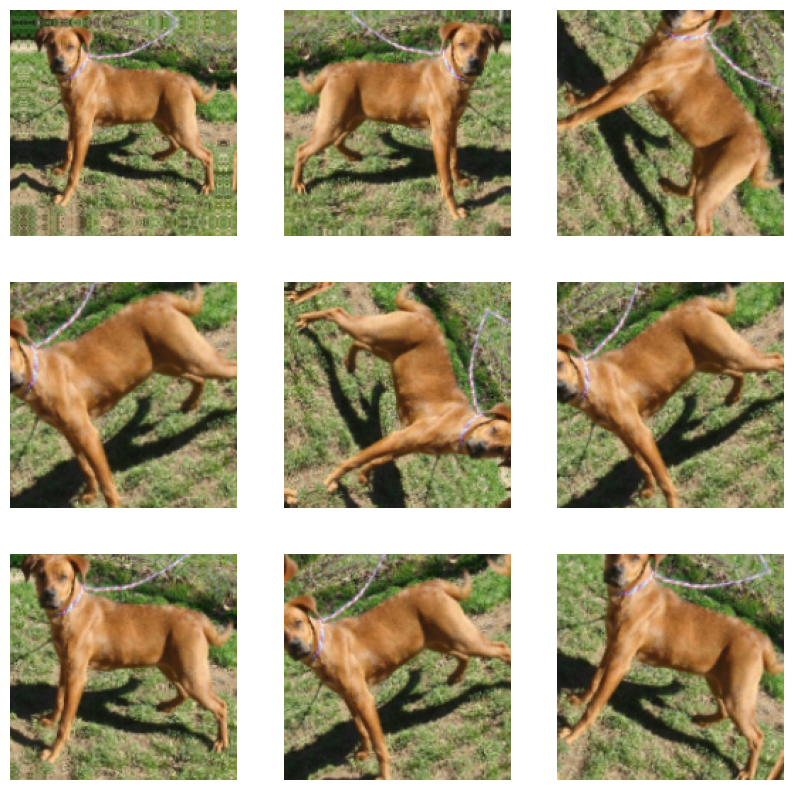

In [9]:
# Show the images after being augmented
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In [10]:
# load the MobileNetV2 preprocess input
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
# create a Recaling layer to rescale the images
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## Create the base model from the pre-trained convnets

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction

### Freeze the convolutional base

In [14]:
# we have to freeze the convolutional base when doing feature extraction
base_model.trainable = False

### Important note about BatchNormalization layers

In [15]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

### Add a classification head

When we do feature extraction, we need to add 1 global average layer and one dense layer

In [16]:
# Add one global average pooling 2D
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
# Apply a tf.keras.layers.Dense
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [18]:
# Build a model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [20]:
len(model.trainable_variables)

2

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Compile the model

Compile the model before training it. Since there are two classes and a sigmoid oputput, use the `BinaryAccuracy`.

In [22]:
# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

### Train the model

In [23]:
# test the initial loss and accuracy of the model
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)


26/26 [==============================] - 5s 107ms/step - loss: 1.0232 - accuracy: 0.3131


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.02
initial accuracy: 0.31


In [25]:
# fit the model with the dataset
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 16s 179ms/step - loss: 0.8733 - accuracy: 0.4665 - val_loss: 0.6968 - val_accuracy: 0.5792
Epoch 2/10
63/63 [==============================] - 11s 168ms/step - loss: 0.6526 - accuracy: 0.6365 - val_loss: 0.5017 - val_accuracy: 0.7847
Epoch 3/10
63/63 [==============================] - 12s 182ms/step - loss: 0.5296 - accuracy: 0.7420 - val_loss: 0.3800 - val_accuracy: 0.8725
Epoch 4/10
63/63 [==============================] - 11s 168ms/step - loss: 0.4340 - accuracy: 0.8100 - val_loss: 0.3138 - val_accuracy: 0.9072
Epoch 5/10
63/63 [==============================] - 10s 159ms/step - loss: 0.3762 - accuracy: 0.8480 - val_loss: 0.2606 - val_accuracy: 0.9257
Epoch 6/10
63/63 [==============================] - 10s 161ms/step - loss: 0.3335 - accuracy: 0.8730 - val_loss: 0.2227 - val_accuracy: 0.9431
Epoch 7/10
63/63 [==============================] - 11s 168ms/step - loss: 0.3038 - accuracy: 0.8880 - val_loss: 0.1944 - val_accuracy: 0.9579

### Learning curves

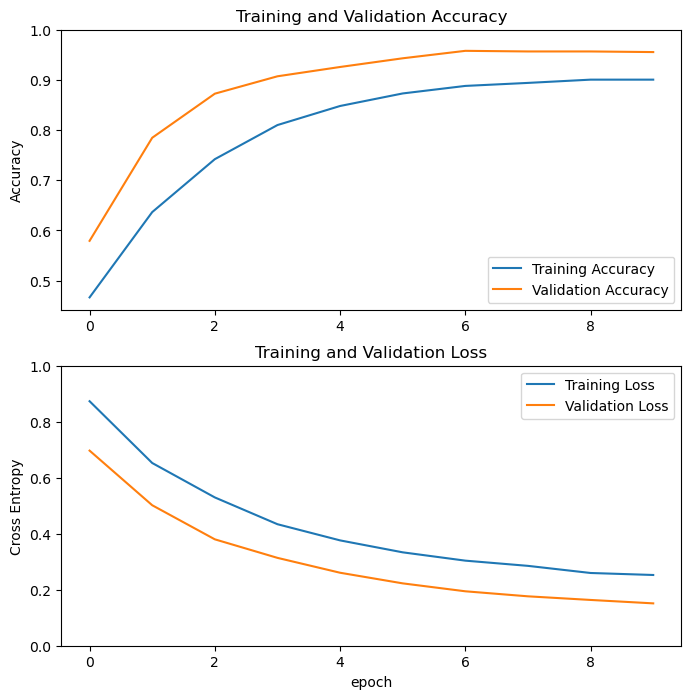

In [26]:
# plot the learning curve and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

When fine-tuning, we have to unfreeze the top layers of the models and then define where we will fine tune from

### Un-freeze the top layers of the model


In [27]:
# Initially set all the layers in the model to be trainable
base_model.trainable = True

In [28]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 80

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [29]:
# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [31]:
# Check for the number of trainable_variables
len(model.trainable_variables)

77

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True 
)

# Define learning rate decay on Plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Create the callbacks
callbacks = [early_stopping, reduce_lr]

# Fine-tune the model
fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=len(history.epoch),
    validation_data=validation_dataset,
    callbacks=callbacks
)


Epoch 11/30
63/63 [==============================] - 28s 292ms/step - loss: 0.1909 - accuracy: 0.9190 - val_loss: 0.0690 - val_accuracy: 0.9790 - lr: 1.0000e-05
Epoch 12/30
63/63 [==============================] - 19s 297ms/step - loss: 0.1394 - accuracy: 0.9445 - val_loss: 0.0741 - val_accuracy: 0.9666 - lr: 1.0000e-05
Epoch 13/30
63/63 [==============================] - 19s 302ms/step - loss: 0.1231 - accuracy: 0.9510 - val_loss: 0.0529 - val_accuracy: 0.9814 - lr: 1.0000e-05
Epoch 14/30
63/63 [==============================] - 20s 313ms/step - loss: 0.1324 - accuracy: 0.9460 - val_loss: 0.0478 - val_accuracy: 0.9827 - lr: 1.0000e-05
Epoch 15/30
63/63 [==============================] - 17s 273ms/step - loss: 0.1053 - accuracy: 0.9610 - val_loss: 0.0547 - val_accuracy: 0.9802 - lr: 1.0000e-05
Epoch 16/30
63/63 [==============================] - 16s 258ms/step - loss: 0.1125 - accuracy: 0.9525 - val_loss: 0.0437 - val_accuracy: 0.9851 - lr: 1.0000e-05
Epoch 17/30
63/63 [===============

In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

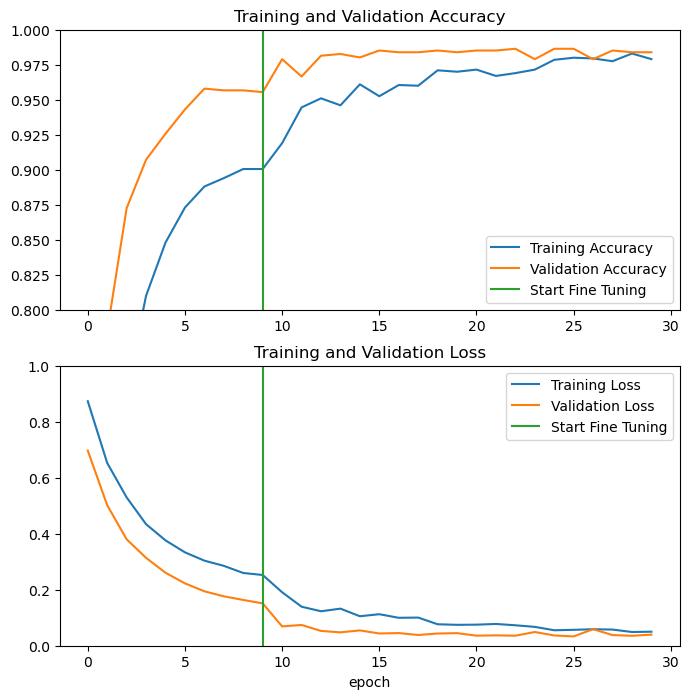

In [34]:
# Plot the training curve and accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [35]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 110ms/step - loss: 0.0135 - accuracy: 0.9948
Test accuracy : 0.9947916865348816


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 1]
Labels:
 [1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 1]


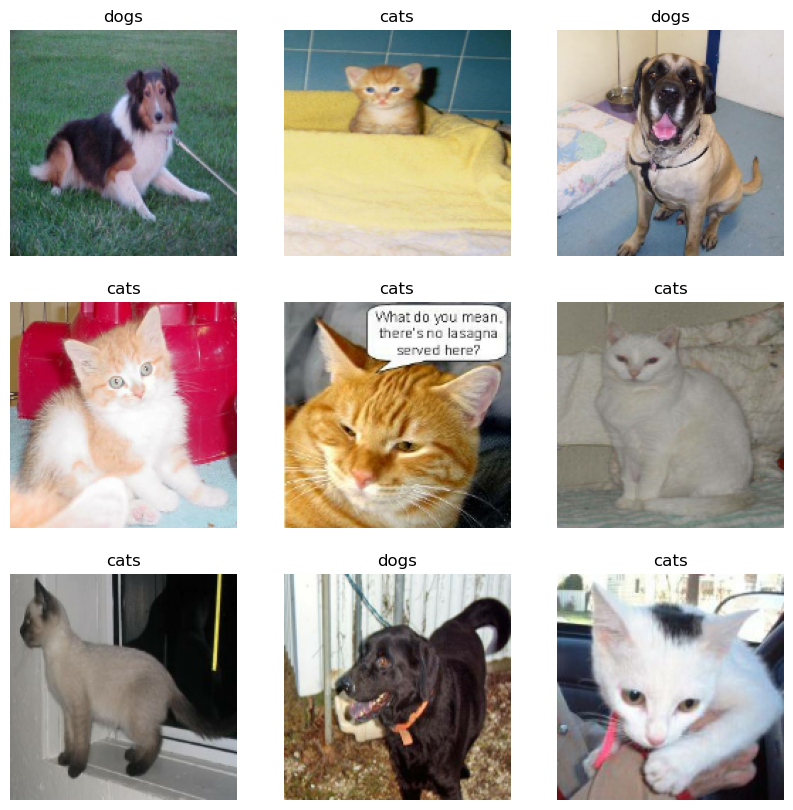

In [36]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")